In [1]:
import pandas as pd 
fish = pd.read_csv('https://bit.ly/fish_csv_data')
fish_input = fish[['Weight', 'Length', 'Diagonal', 'Height', 'Width']].to_numpy()
fish_target = fish['Species'].to_numpy()

In [2]:
fish

,Species,Weight,Length,Diagonal,Height,Width
0,Bream,242.0,25.4,30.0,11.5200,4.0200
1,Bream,290.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,26.5,31.1,12.3778,4.6961
3,Bream,363.0,29.0,33.5,12.7300,4.4555
4,Bream,430.0,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...
154,Smelt,12.2,12.2,13.4,2.0904,1.3936
155,Smelt,13.4,12.4,13.5,2.4300,1.2690
156,Smelt,12.2,13.0,13.8,2.2770,1.2558
157,Smelt,19.7,14.3,15.2,2.8728,2.0672


pandas.dataframe을 numpy 형태로 바꾼거?

In [3]:
# 데이터 세트 나누기
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(fish_input, fish_target, random_state=42)

#### train_test_split의 파라미터

- arrays : 분할시킬 데이터를 입력 (Python list, Numpy array, Pandas dataframe 등..)

- test_size : 테스트 데이터셋의 비율(float)이나 갯수(int) (default = 0.25)

- train_size : 학습 데이터셋의 비율(float)이나 갯수(int) (default = test_size의 나머지)

- random_state : 데이터 분할시 셔플이 이루어지는데 이를 위한 시드값 (int나 RandomState로 입력)

- shuffle : 셔플여부설정 (default = True)

- stratify : 지정한 Data의 비율을 유지한다. 예를 들어, Label Set인 Y가 25%의 0과 75%의 1로 이루어진 Binary Set일 때, stratify=Y로 설정하면 나누어진 데이터셋들도 0과 1을 각각 25%, 75%로 유지한 채 분할된다.


In [4]:
# 데이터 전처리
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

StandardScaler는 모든 피처들을 평균이 0, 분산이 1인 정규분포를 갖도록 만들어줍니다.(표준화 하는 방법)

데이터 내에 이상치가 있다면 적절한 방법이 아닙니다

ss.fit(train_input)은 train_input 데이터의 평균과 표준 편차를 계산하여 이 정보를 ss 객체에 저장합니다.

그 후 transform 매서드를 이용해 train_input을 표준 정규 분포로 변환

그다음 SDGClassifier 클래스를 불러서 모델을 학습시킨다. 

SDGClassifier는 손실함수를 의미하는 'loss'매개변수와 에포크 횟수(훈련 반복 횟수)를 의미하는 'max_iter'를 지정해야 한다.
여기서는 loss에 log함수를 입력했고 max_iter에 10을 입력했다. 

loss 매개변수에서 log는 로지스틱 손실 함수를 의미한다. 
매개변수를 다 설정했다면 score함수를 이용해 정확도를 알아보면 된다

In [6]:
# SDGClassifier 모델 학습
from sklearn.linear_model import SGDClassifier
sc = SGDClassifier(loss='log', max_iter=10, random_state=42)
sc.fit(train_scaled, train_target)
print(sc.score(train_scaled, train_target))
print(sc.score(test_scaled, test_target))

0.773109243697479
0.775


C:\Users\byeongwan\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


정확도를 확인한 이후 에포크를 한 번 더 실행하고자 한다면 'partial_fit'을 이용하면 된다.

partial_fit은 fit과 동일한 역할을 하지만 모델을 처음부터 학습시키는 것이 아니라 기존의 실행했던 에포크 횟수에서 1회씩 추가적으로 학습하게 한다.

In [7]:
# 에포크 횟수 1회 추가
sc.partial_fit(train_scaled, train_target)
print(sc.score(train_scaled, train_target))
print(sc.score(test_scaled, test_target))

0.8151260504201681
0.85


하지만 매번 1회씩 에포크를 늘리면서 최적의 학습 횟수를 찾기가 번거로울 뿐만 아니라 자칫하면 모델이 과대적합이 될 수 있다.

따라서 이전에 라쏘회귀와 릿지회귀 때 규제 강도를 조절하면서 최적의 규제 강도를 찾았던 거처럼, 에포크도 횟수에 따라 정확도가 어떻게 변하는 지 알아보는 것이 좋다.

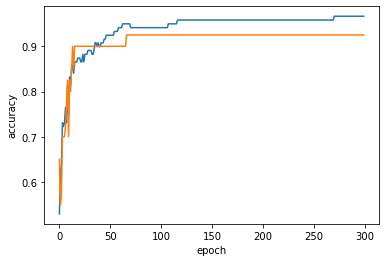

In [8]:
# 최적의 에포크 횟수 찾기
import numpy as np 
sc = SGDClassifier(loss='log', random_state=42)
train_score = []
test_score = []
classes = np.unique(train_target)

for _ in range(0, 300) :
    sc.partial_fit(train_scaled, train_target, classes=classes)
    train_score.append(sc.score(train_scaled, train_target))
    test_score.append(sc.score(test_scaled, test_target))

import matplotlib.pyplot as plt 
plt.plot(train_score)
plt.plot(test_score)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

코드로 실현된 그래프를 보면 
약 60 ~ 70회 정도까지는 테스트와 훈련 데이터 간의 정확도가 차이가 크게 차이나고 있지 않다가 120~130회쯤 정확도가 점점 벌어지고 있다. 

따라서 대략적으로 에포크 횟수를 100으로 지정하면 좋겠다는 판단을 내리면 된다.


https://m.blog.naver.com/psycomaniac/222487950329